In [11]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../Datasets/MET_weather/hly532.csv", skiprows=23)
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


date  ind  rain  ind.1  temp  ind.2  wetb  dewpt vappr rhum  \
0  01-jan-1989 00:00    3   0.0      0   6.8      0   5.9    4.7   8.6   87   
1  01-jan-1989 01:00    3   0.0      0   7.9      0   6.4    4.5   8.4   79   
2  01-jan-1989 02:00    3   0.0      0   7.9      0   6.3    4.2   8.3   78   
3  01-jan-1989 03:00    3   0.0      0   7.2      0   6.2    4.9   8.7   85   
4  01-jan-1989 04:00    3   0.0      0   6.2      0   5.5    4.6   8.5   89   

   ...    ind.3  wdsp  ind.4  wddir  ww   w  sun   vis  clht  clamt  
0  ...        2     5      2    230  10  10  0.0  6000   999      0  
1  ...        2     6      2    230  10   0  0.0  8000   999      0  
2  ...        2     6      2    220  10   0  0.0  9000   999      0  
3  ...        2     5      2    230  10   0  0.0  9000   999      0  
4  ...        2     6      2    220  10   0  0.0  9000   999      0  

[5 rows x 21 columns]

# Cleaning

In [3]:
data2 = data[:10000].copy()
data2.rename(axis="columns", inplace=True,
            mapper={"ind": "irain", 
                    "ind.1": "itemp", 
                    "ind.2": "iwb", 
                    "ind.3": "iwdsp", 
                    "ind.4": "iwddir"})

# Convert types
categorical_cols = ["irain", "itemp", "iwb", "iwdsp", "iwddir", "w", "ww"]
data2[categorical_cols] = data2[categorical_cols].astype(int, errors="ignore").astype("category")

mixed_cols = ["vappr", "rhum", "wddir"]
data2.loc[:, mixed_cols] = data2[mixed_cols].apply(pd.to_numeric, errors="coerce")
data2.loc[:, "date"] = pd.to_datetime(data2["date"])

# Properly label nan values
nan_values = {
    "clht": 999,
    "itemp": 4,
    "iwdsp": 7,
    "iwddir": 7,
}
for col, val in nan_values.items():
    data2.loc[data2[col] == val, col] = np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA370E8828>,
      dtype=object)

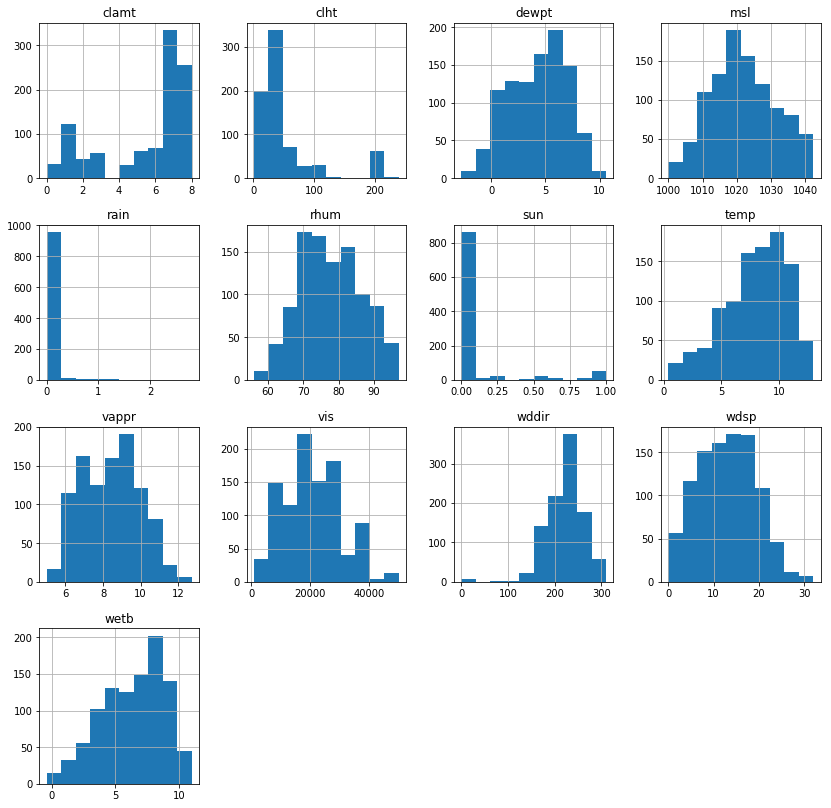

In [4]:
data2.hist(figsize=(14, 14))

# Preprocessing

In [4]:
def norm(df):
    # Normalises all numeric columns of a dataframe
    # (X - mean) / std
    nums = df._get_numeric_data()
    nums =  (nums - nums.mean()) / nums.std()
    
    norm_df = df.copy()
    norm_df.loc[:, nums.columns] = nums
    return norm_df

In [5]:
data3 = norm(data2)._get_numeric_data().fillna(0)

# PCA

In [7]:
from sklearn.decomposition import PCA

In [72]:
pca = PCA(n_components=10)
pca.fit(data3)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [74]:
pca.explained_variance_ratio_ > 0.1

array([ True,  True,  True, False, False, False, False, False, False,
       False])

In [75]:
y = pca.transform(data3)
y_df = pd.DataFrame(y, index=data2["date"])

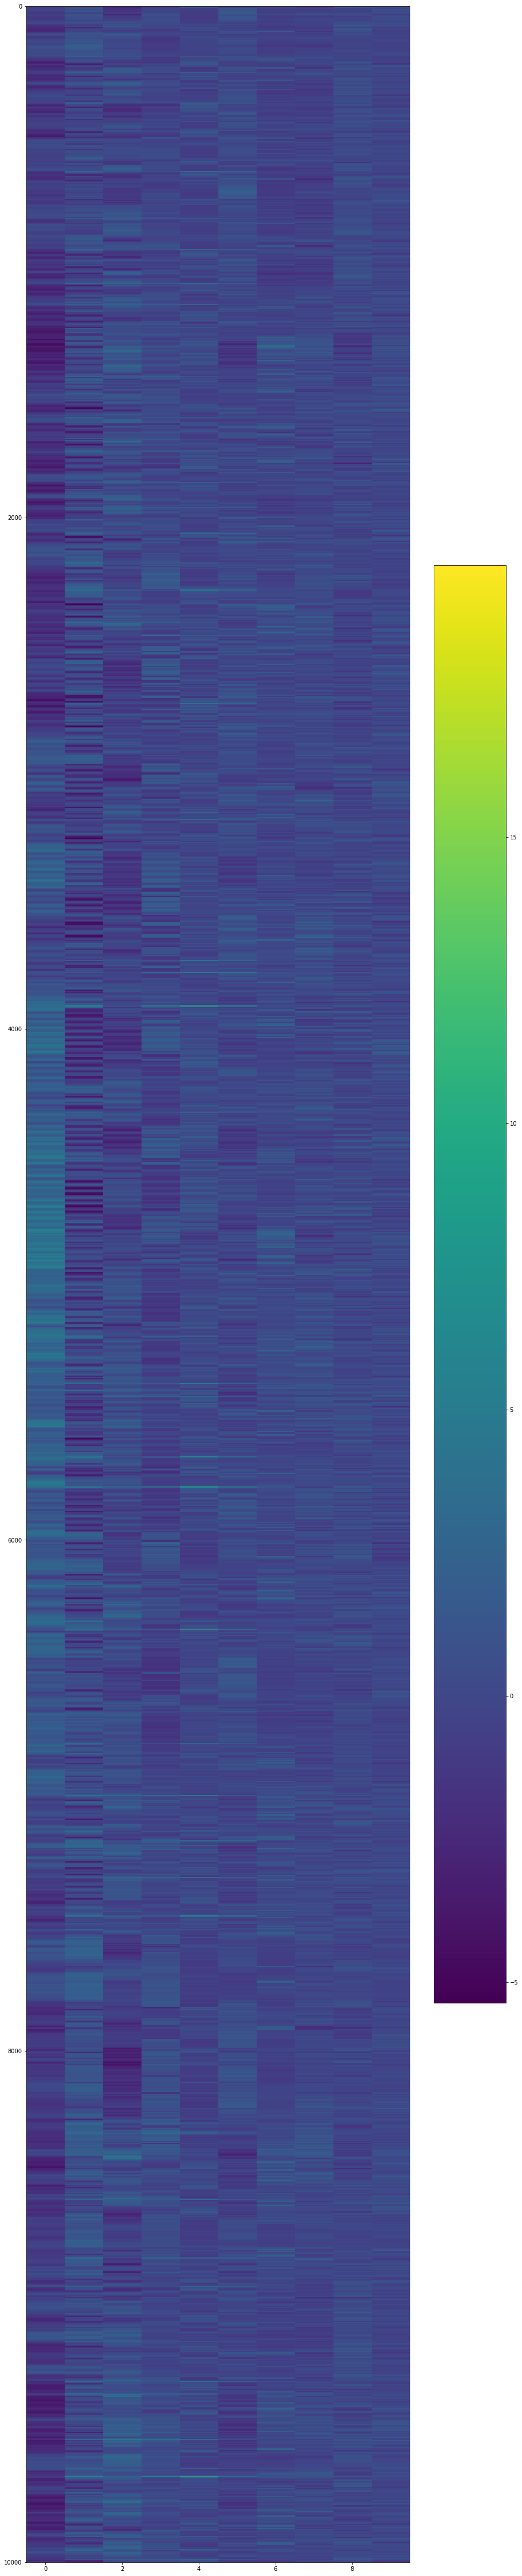

In [76]:
plt.figure(figsize=(15, 100))
plt.imshow(y, aspect=1/150, cmap=matplotlib.cm.viridis,)
plt.colorbar()

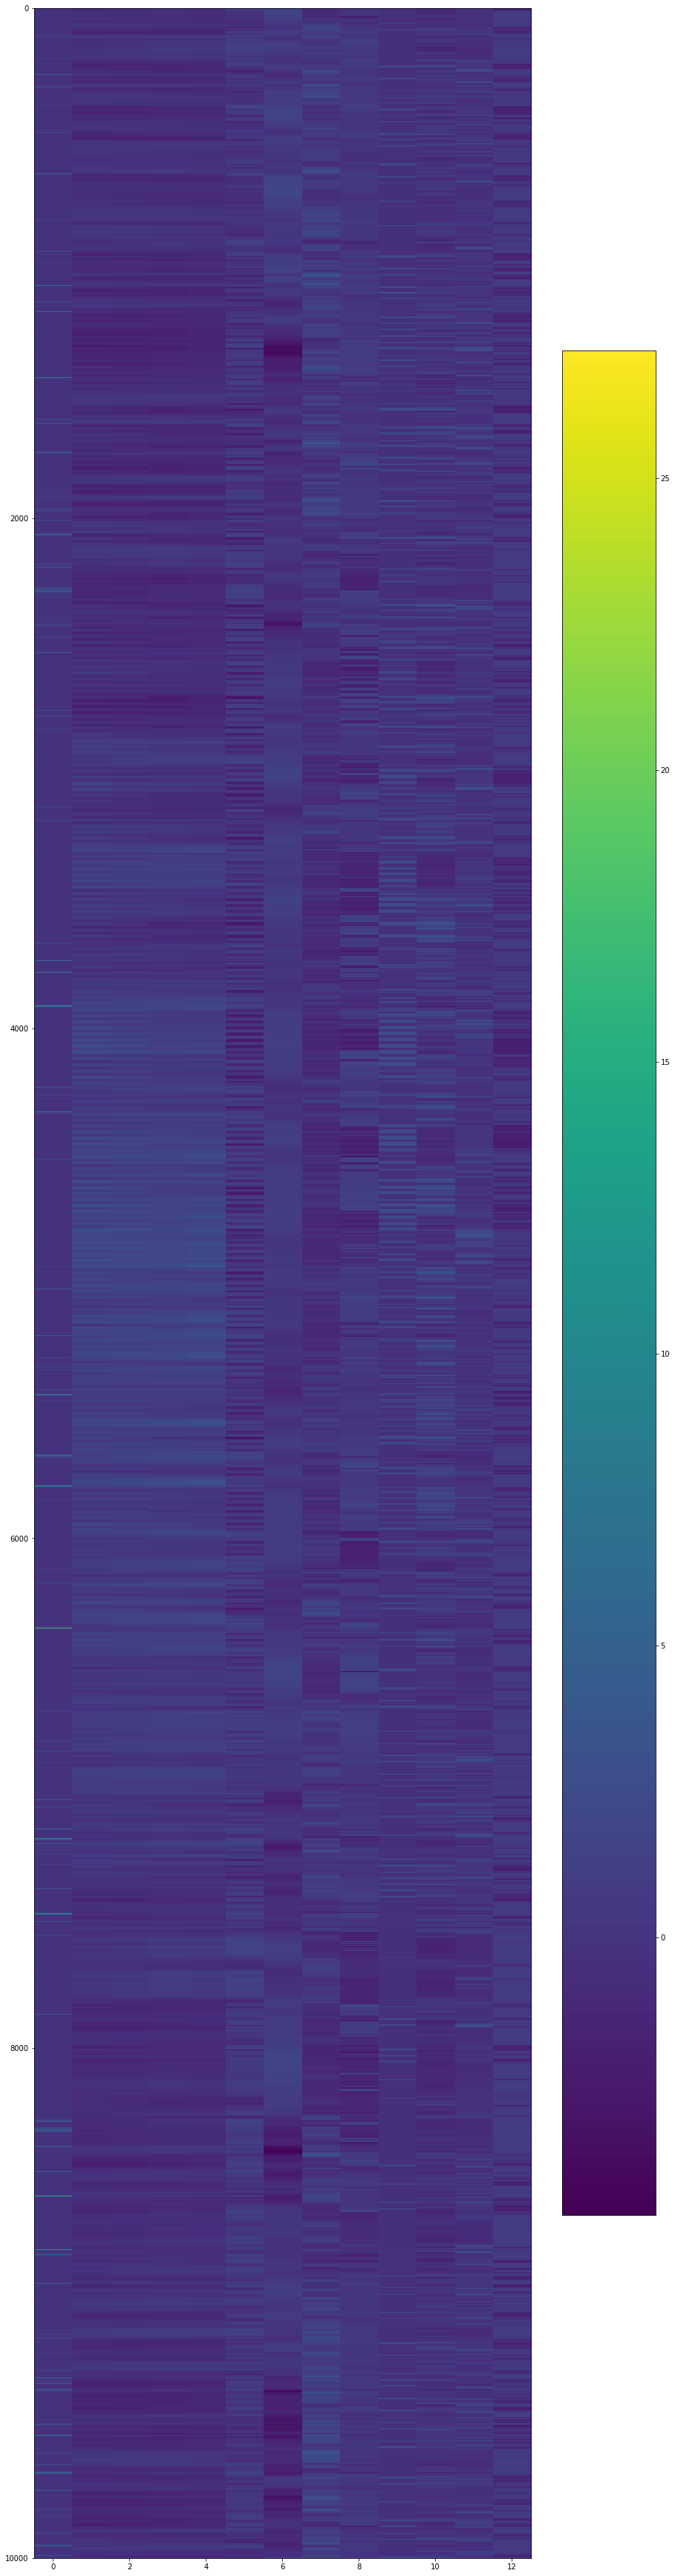

In [77]:
plt.figure(figsize=(15, 100))
plt.imshow(data3, aspect=1/150, cmap=matplotlib.cm.viridis,)
plt.colorbar()

Text(0,0.5,'Component')

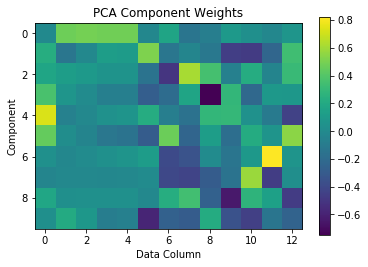

In [78]:
plt.imshow(pca.components_,)

plt.colorbar()
plt.title("PCA Component Weights")
plt.xlabel("Data Column")
plt.ylabel("Component")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E4C1590EF0>,
      dtype=object)

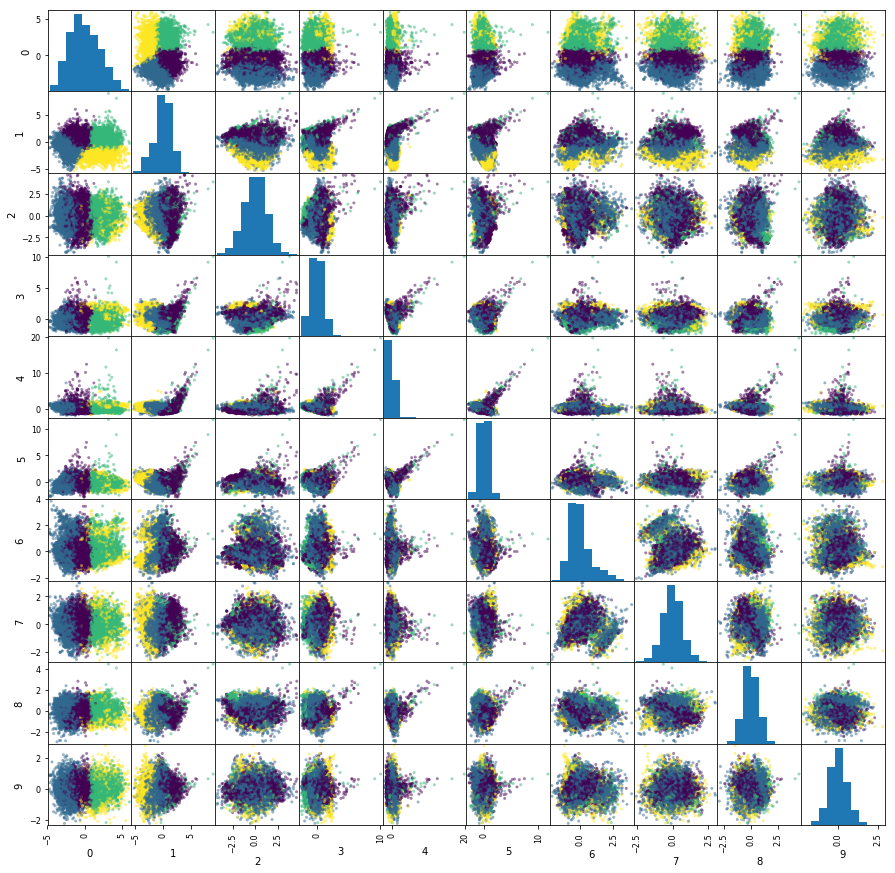

In [93]:
pd.plotting.scatter_matrix(y_df, figsize=(15, 15), c=kmeans.labels_)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E4B69FE6D8>,
      dtype=object)

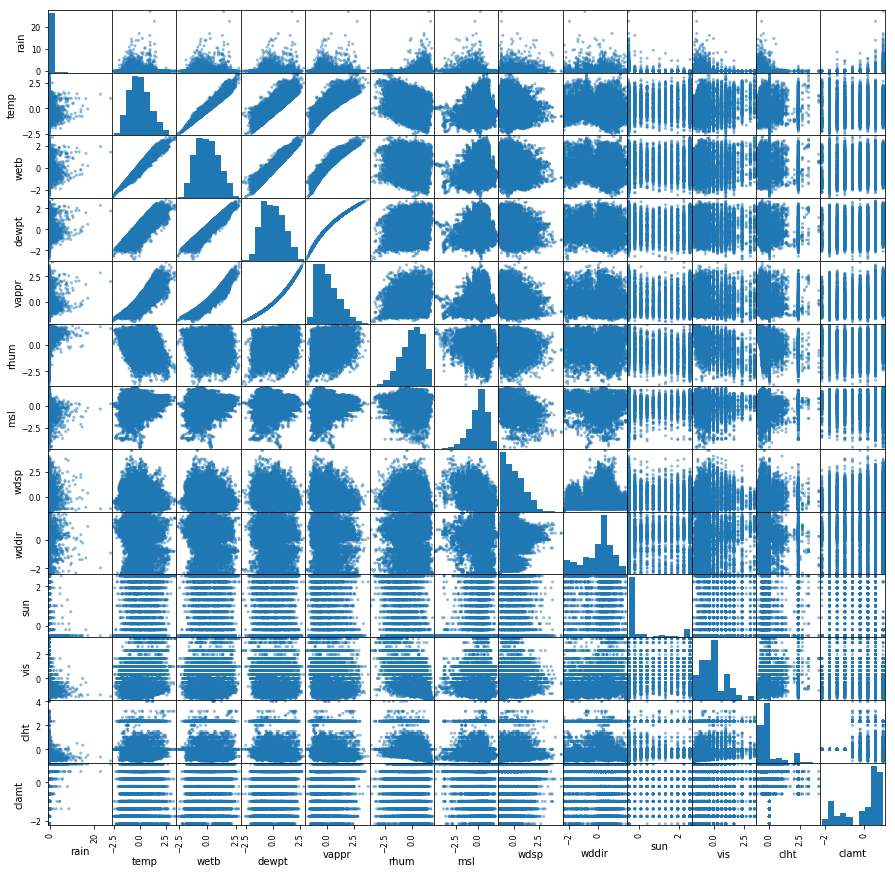

In [80]:
pd.plotting.scatter_matrix(data3, figsize=(15, 15))

# Prediction

### Clustering

In [81]:
from sklearn.cluster import KMeans

In [92]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5,1,'Error vs n clusters')

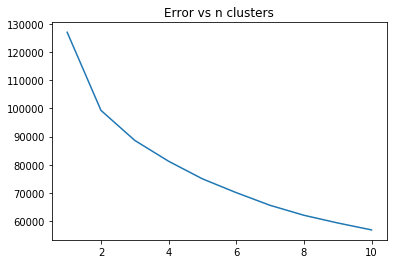

In [94]:
inertias = []
for i in range(10):
    kmeans = KMeans(n_clusters=(i+1))
    kmeans.fit(y)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertias)
plt.title("Error vs n clusters")

### Classification

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm

##### Linear SVM

In [117]:
svm1 = svm.LinearSVC()
svm1.fit(y, data2["ww"])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [136]:
(svm1.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.6741

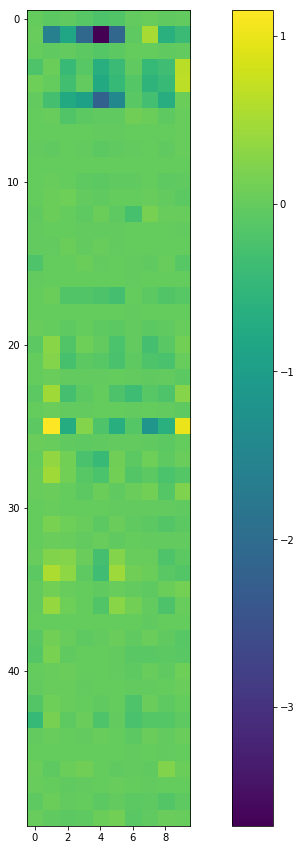

In [129]:
plt.figure(figsize=(15, 15))
plt.imshow(svm1.coef_)
plt.colorbar()

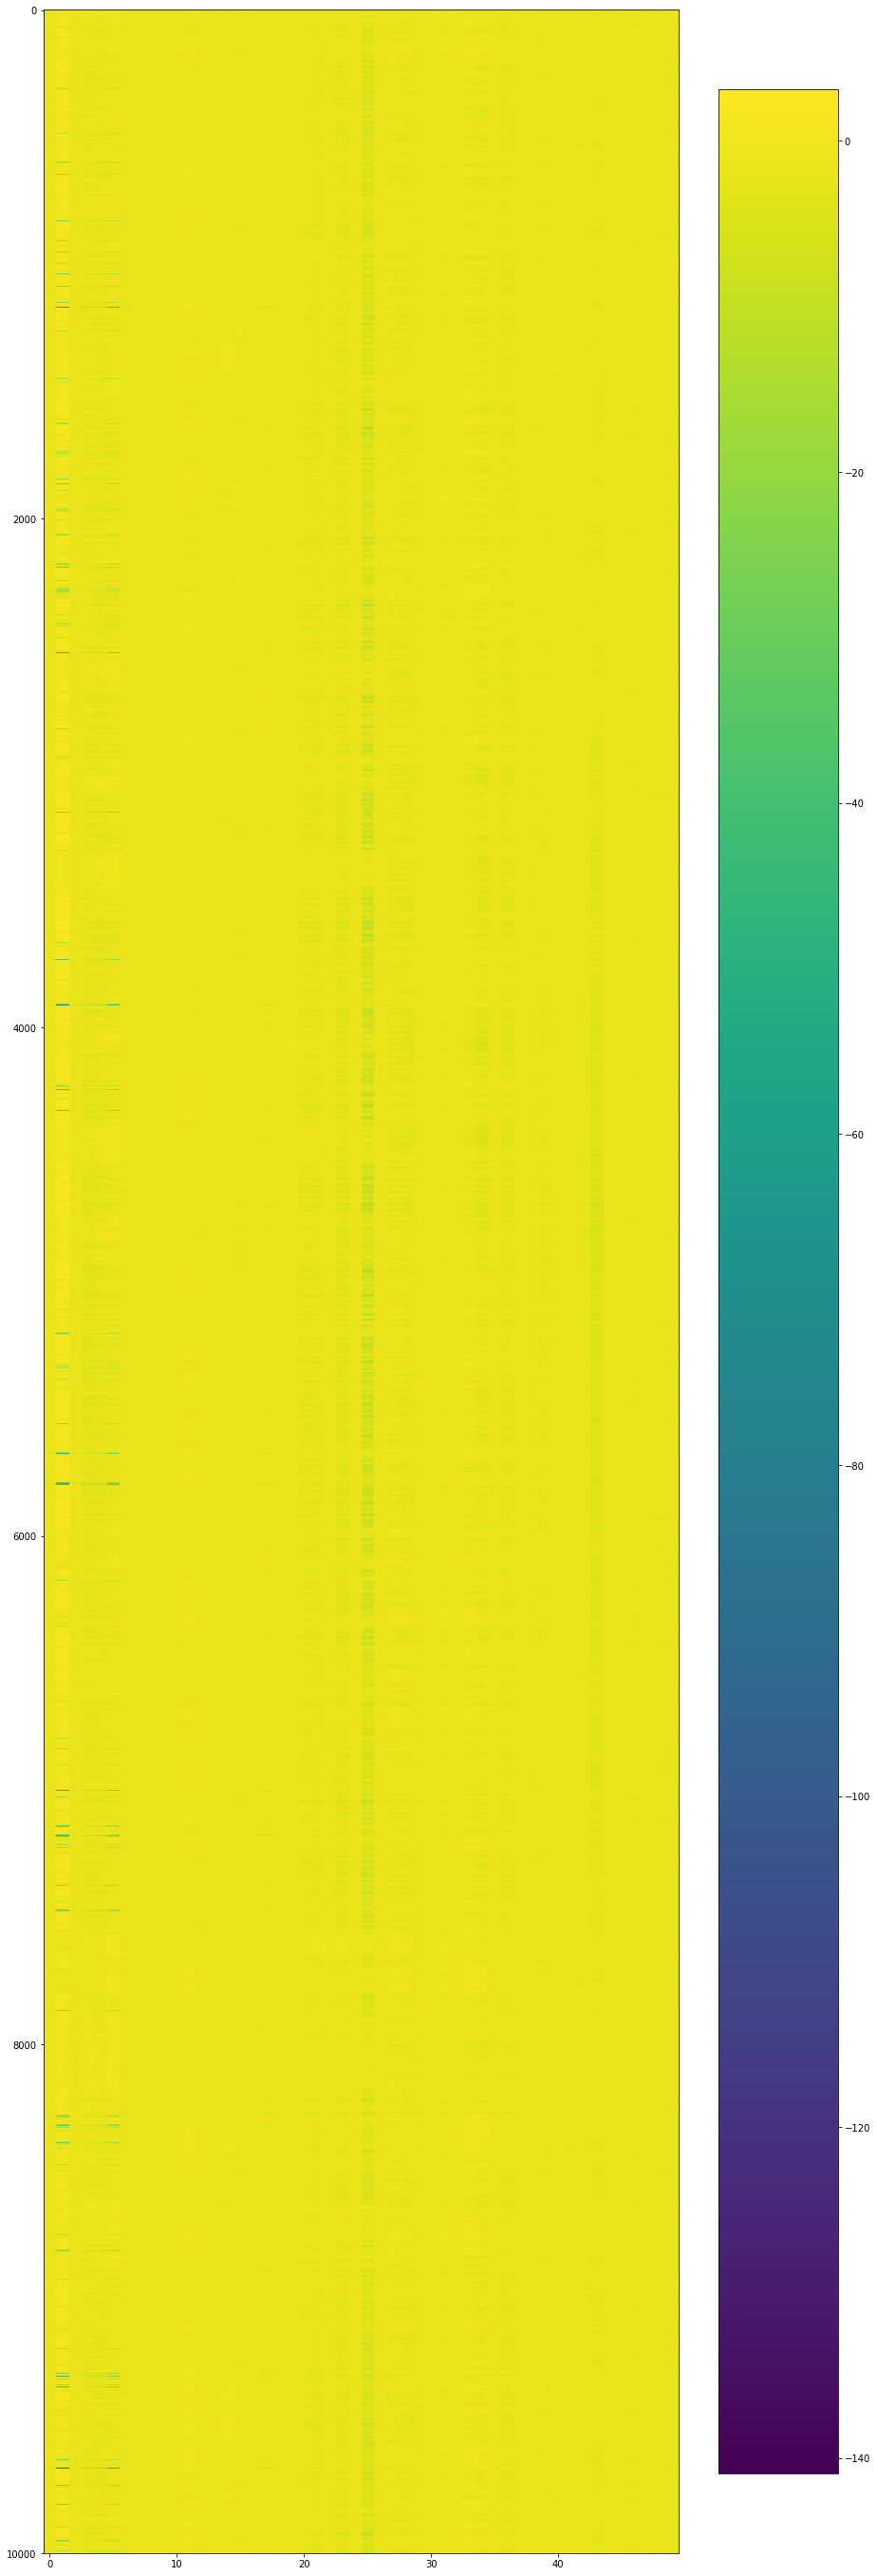

In [143]:
plt.figure(figsize=(15, 100))
plt.imshow(svm1.decision_function(y), aspect=1/50)
plt.colorbar()

##### Poly SVM

In [153]:
svm2 = svm.SVC()
svm2.fit(y, data2["ww"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [154]:
(svm2.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.7177

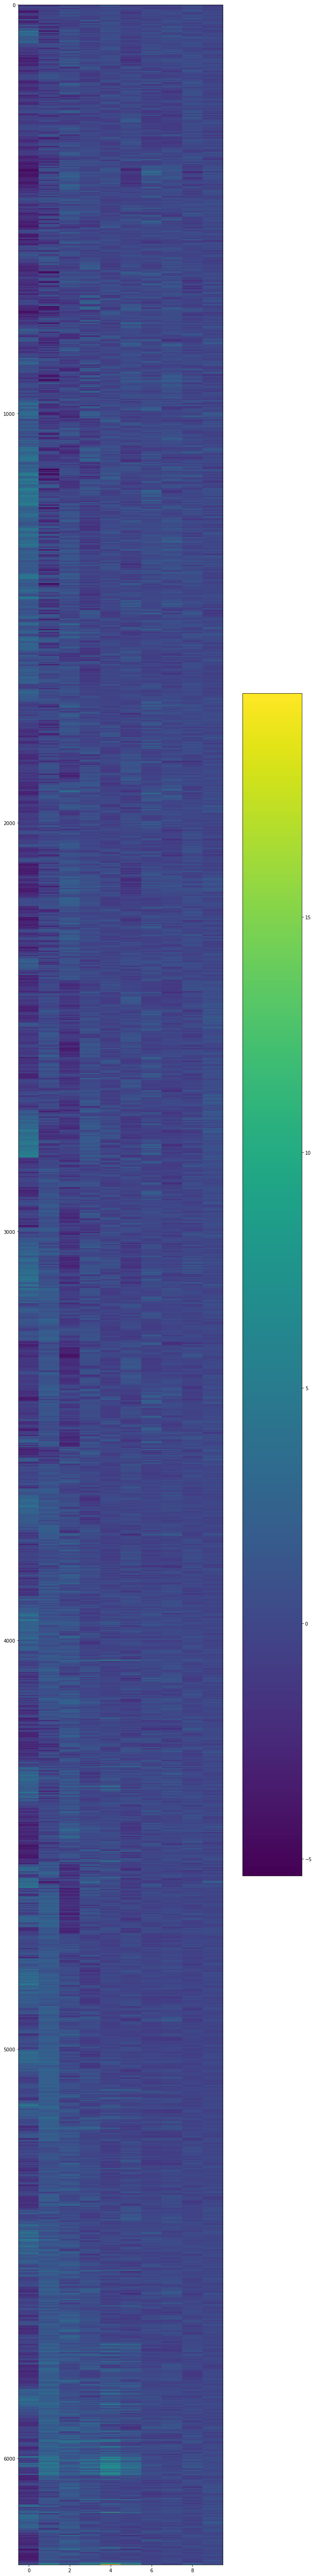

In [156]:
plt.figure(figsize=(15, 100))
plt.imshow(svm2.support_vectors_, aspect=1/50)
plt.colorbar()

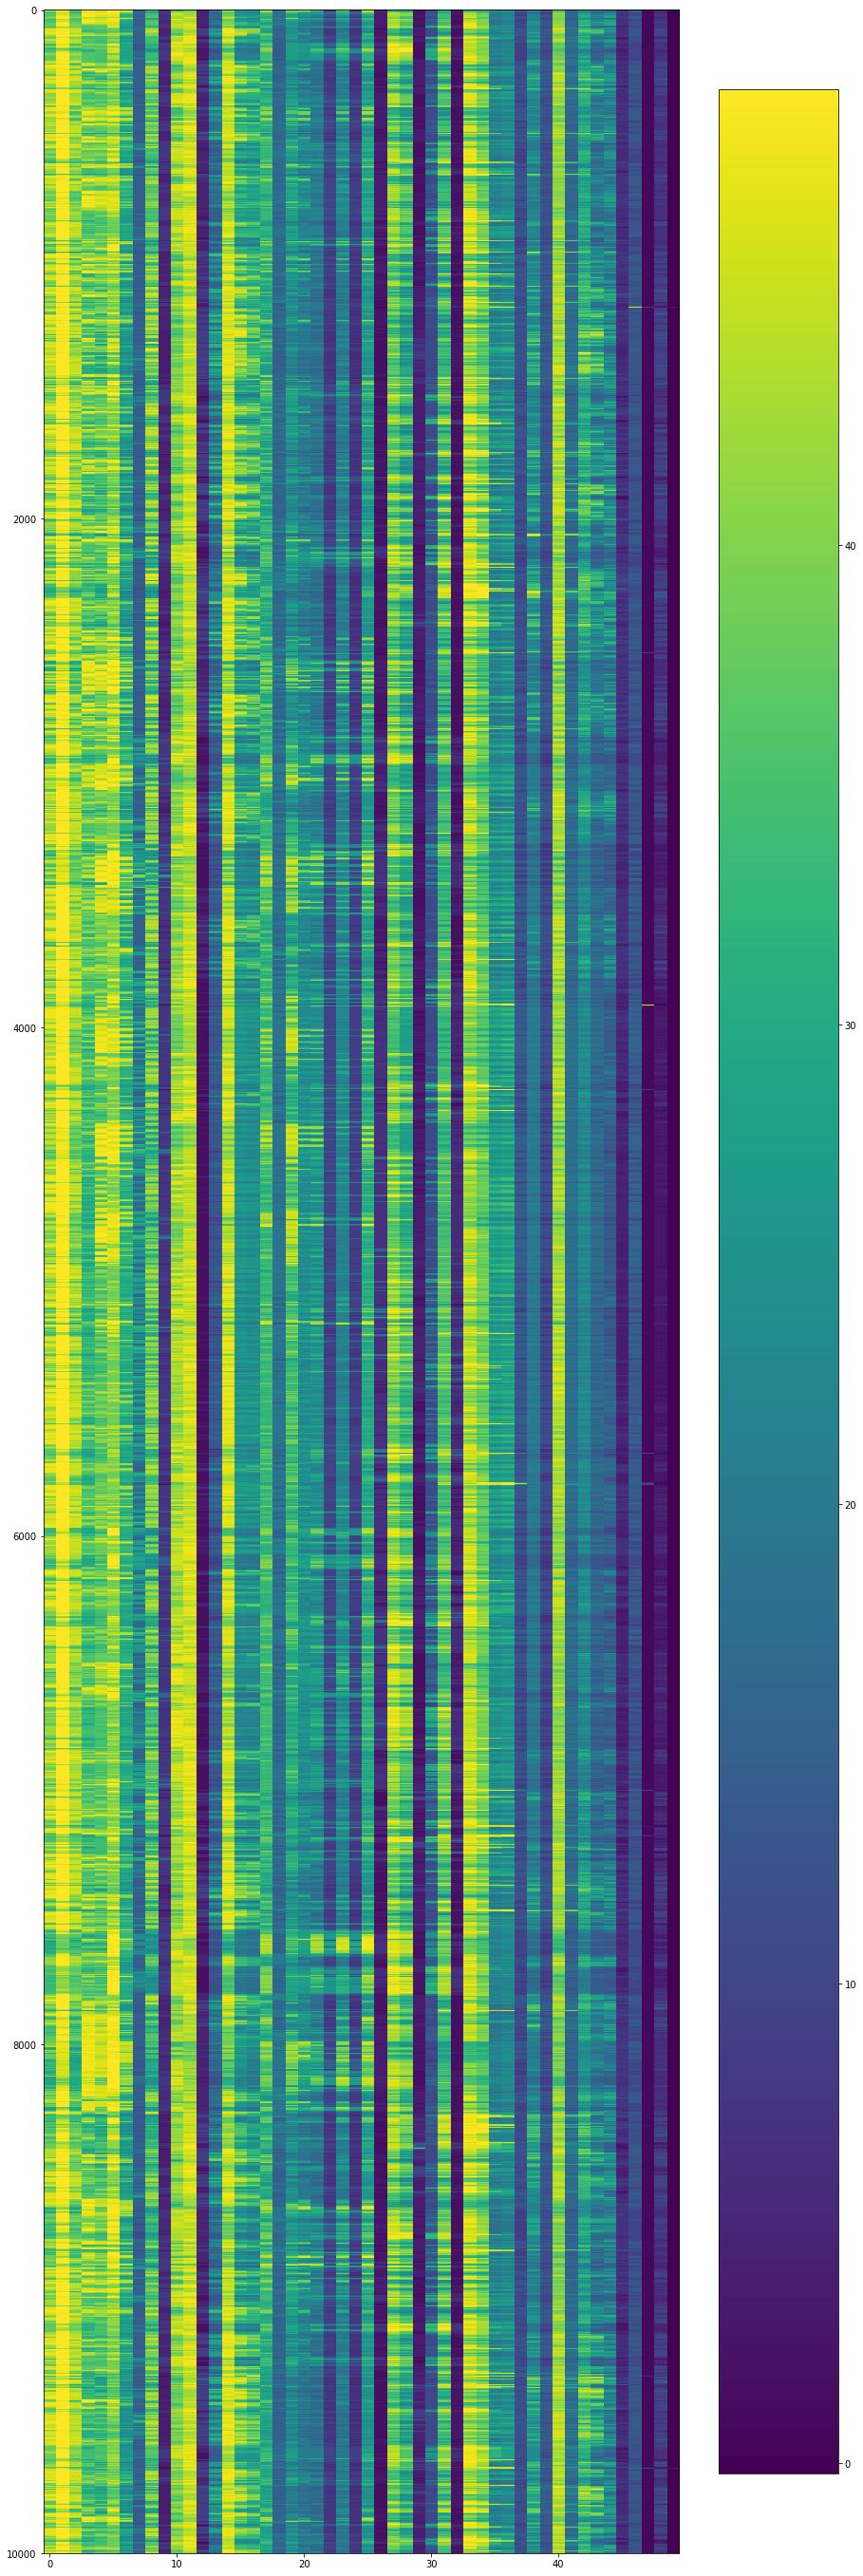

In [161]:
plt.figure(figsize=(15, 100))
plt.imshow(svm2.decision_function(y), aspect=1/50)
plt.colorbar()

##### Nearest Neighbours

In [169]:
from sklearn.neighbors import KNeighborsClassifier

In [171]:
nn = KNeighborsClassifier().fit(y, data2["ww"])

In [175]:
(nn.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.7613

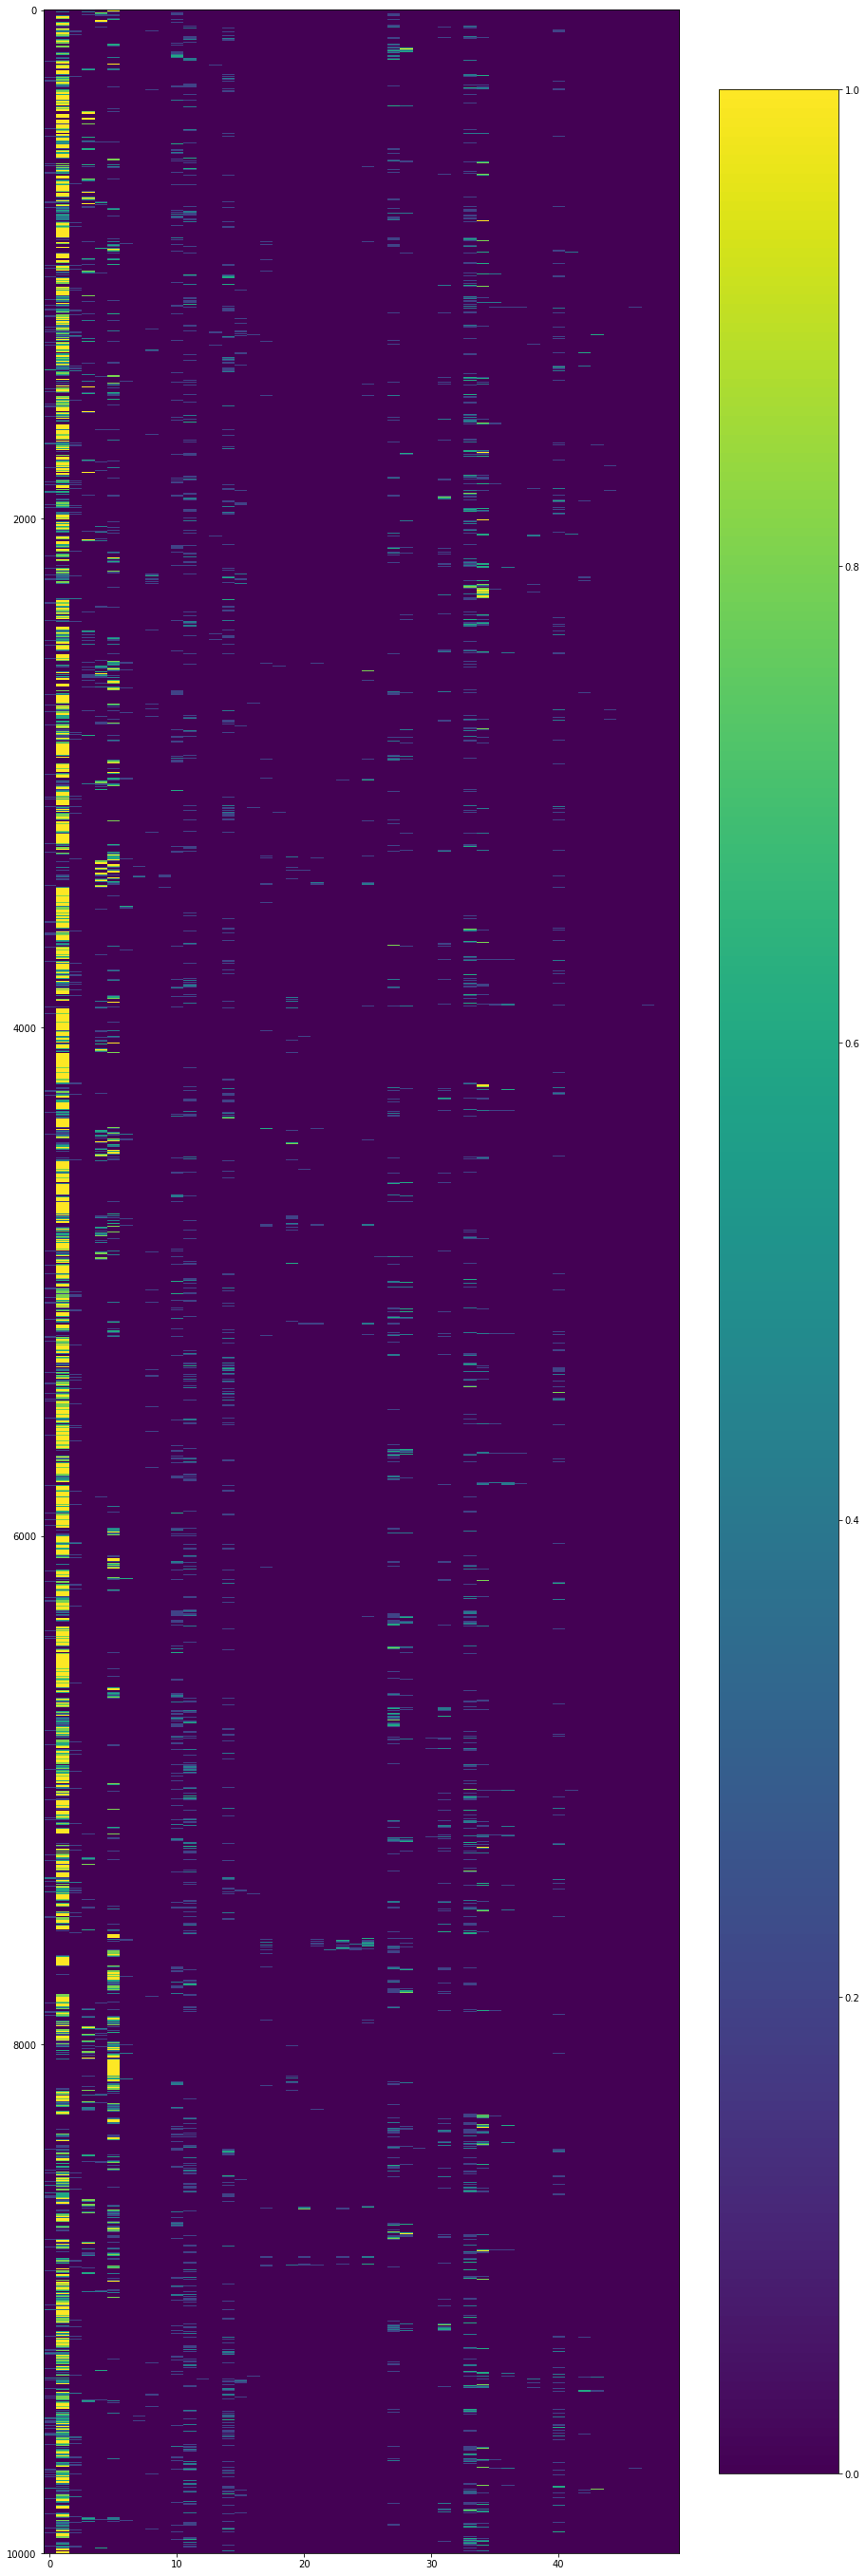

In [176]:
plt.figure(figsize=(15, 100))
plt.imshow(nn.predict_proba(y), aspect=1/50)
plt.colorbar()

##### Gaussian Naive Bayes

In [189]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [184]:
bayesG = GaussianNB().fit(y, data2["ww"])

In [185]:
(bayesG.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.6162

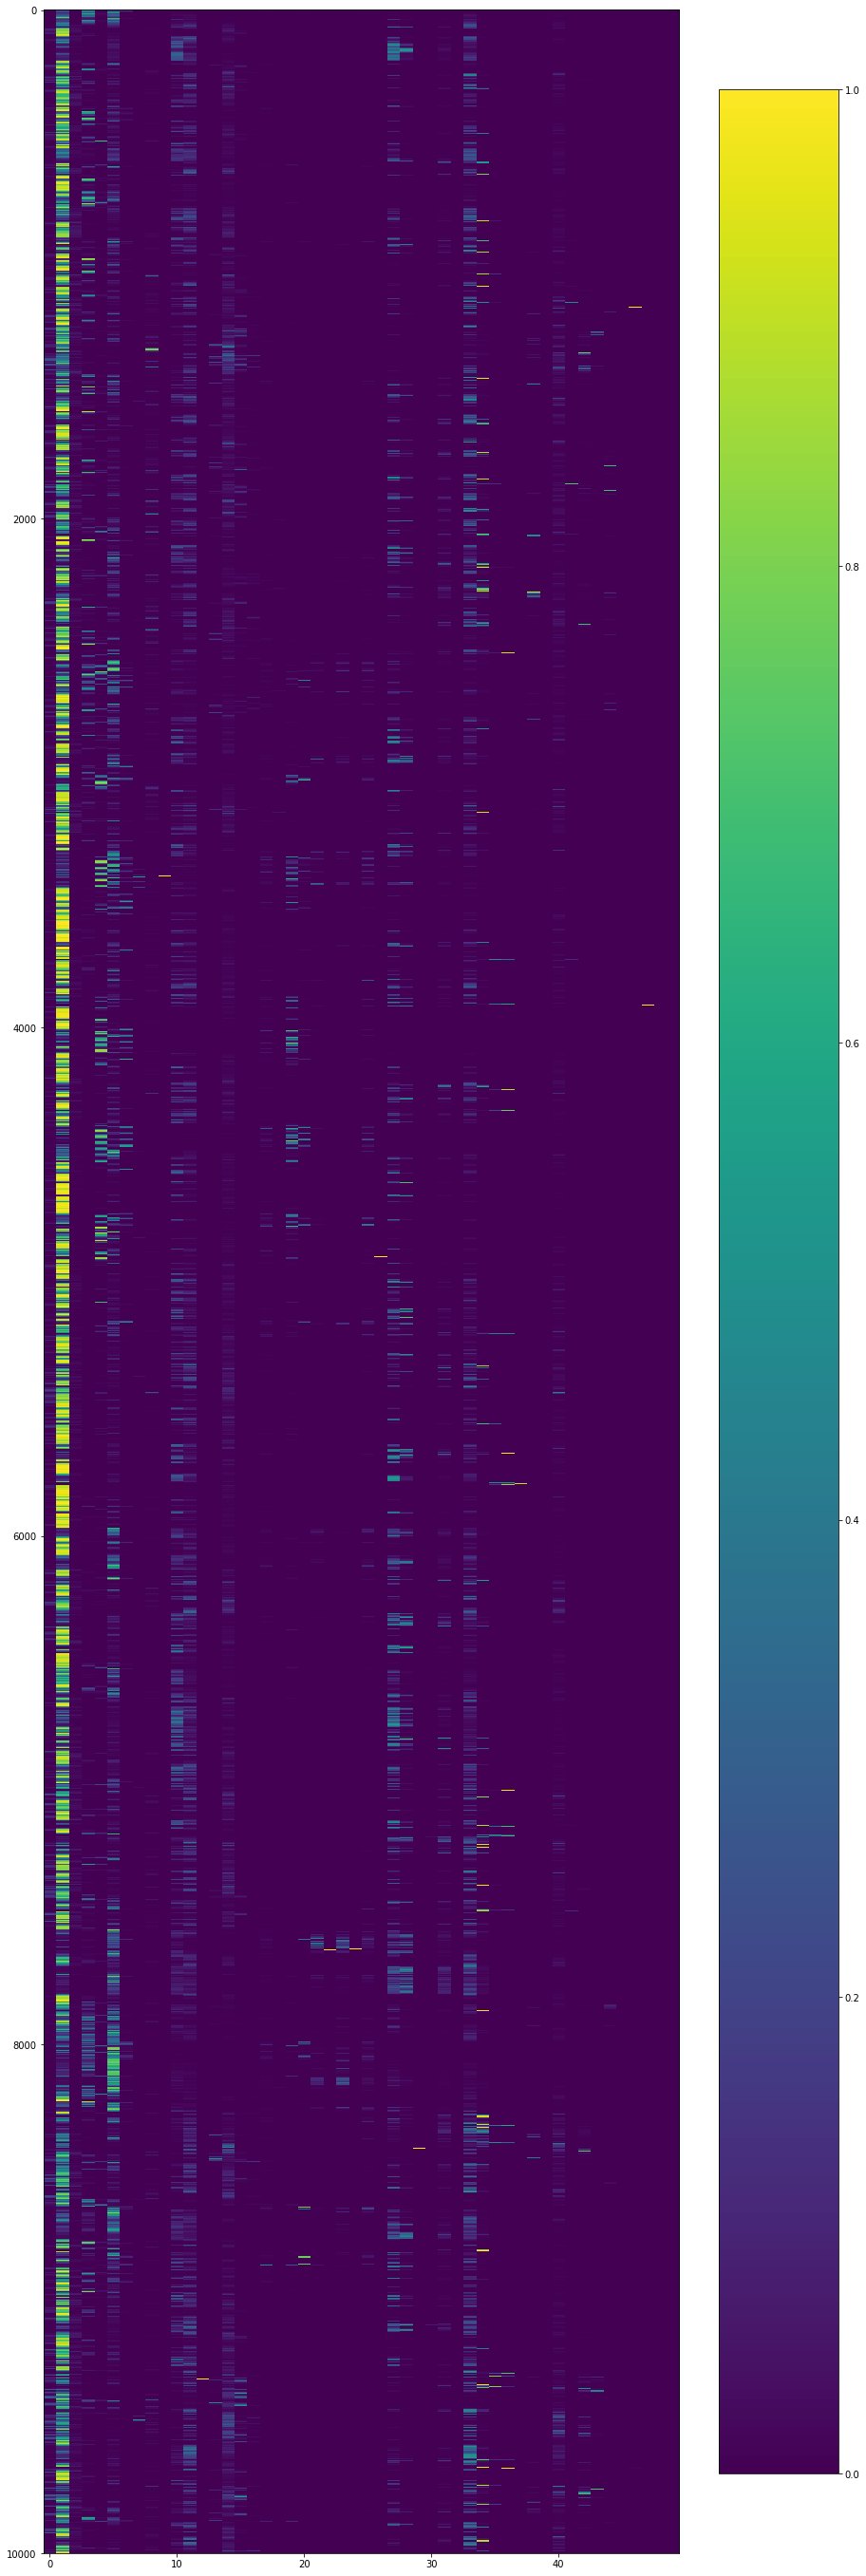

In [186]:
plt.figure(figsize=(15, 100))
plt.imshow(bayesG.predict_proba(y), aspect=1/50)
plt.colorbar()

##### Decision Tree

In [191]:
from sklearn import tree

In [194]:
dtree = tree.DecisionTreeClassifier().fit(y, data2["ww"])

In [195]:
(dtree.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.9999

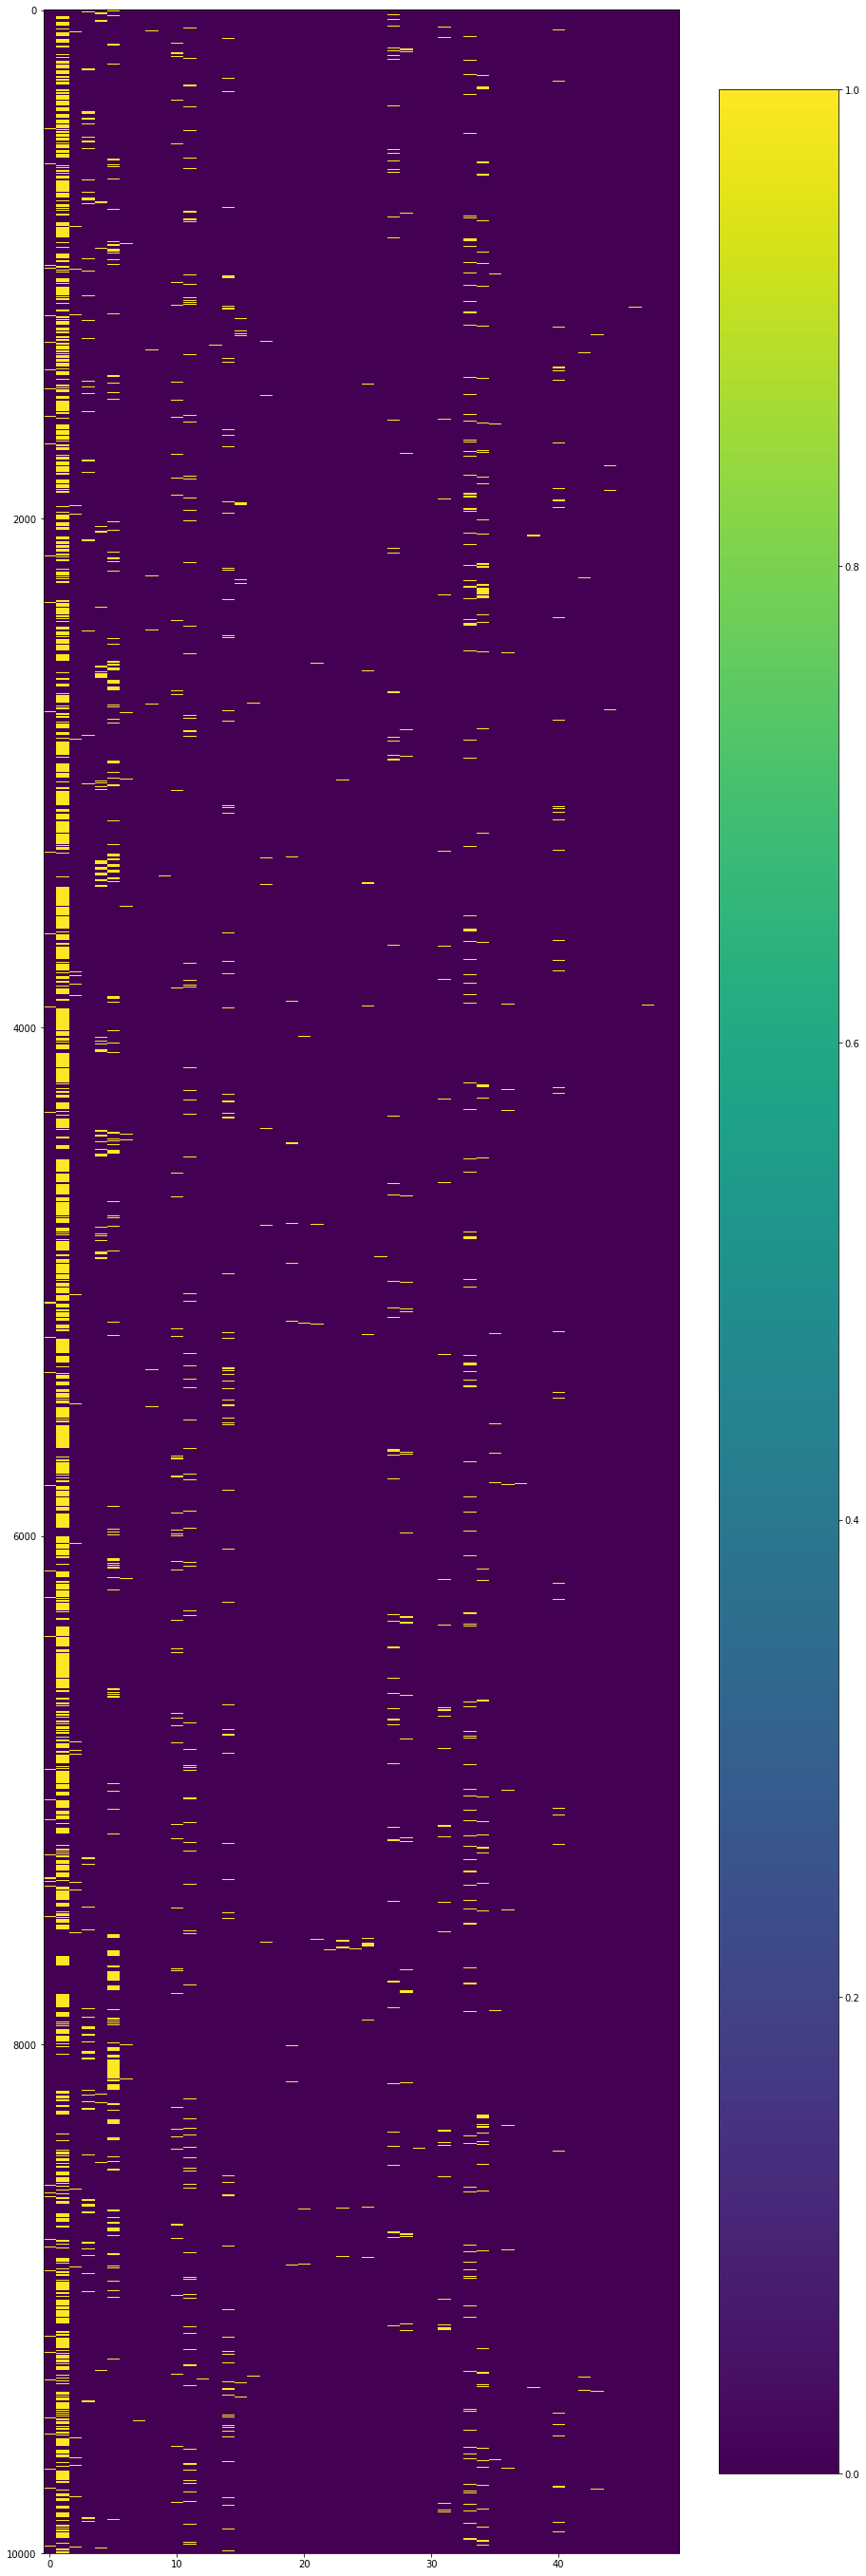

In [197]:
plt.figure(figsize=(15, 100))
plt.imshow(dtree.predict_proba(y), aspect=1/50)
plt.colorbar()

#### Ensembles
##### Random Forest

In [198]:
from sklearn.ensemble import RandomForestClassifier

In [199]:
rforest = RandomForestClassifier().fit(y, data2["ww"])

In [200]:
(rforest.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.9846

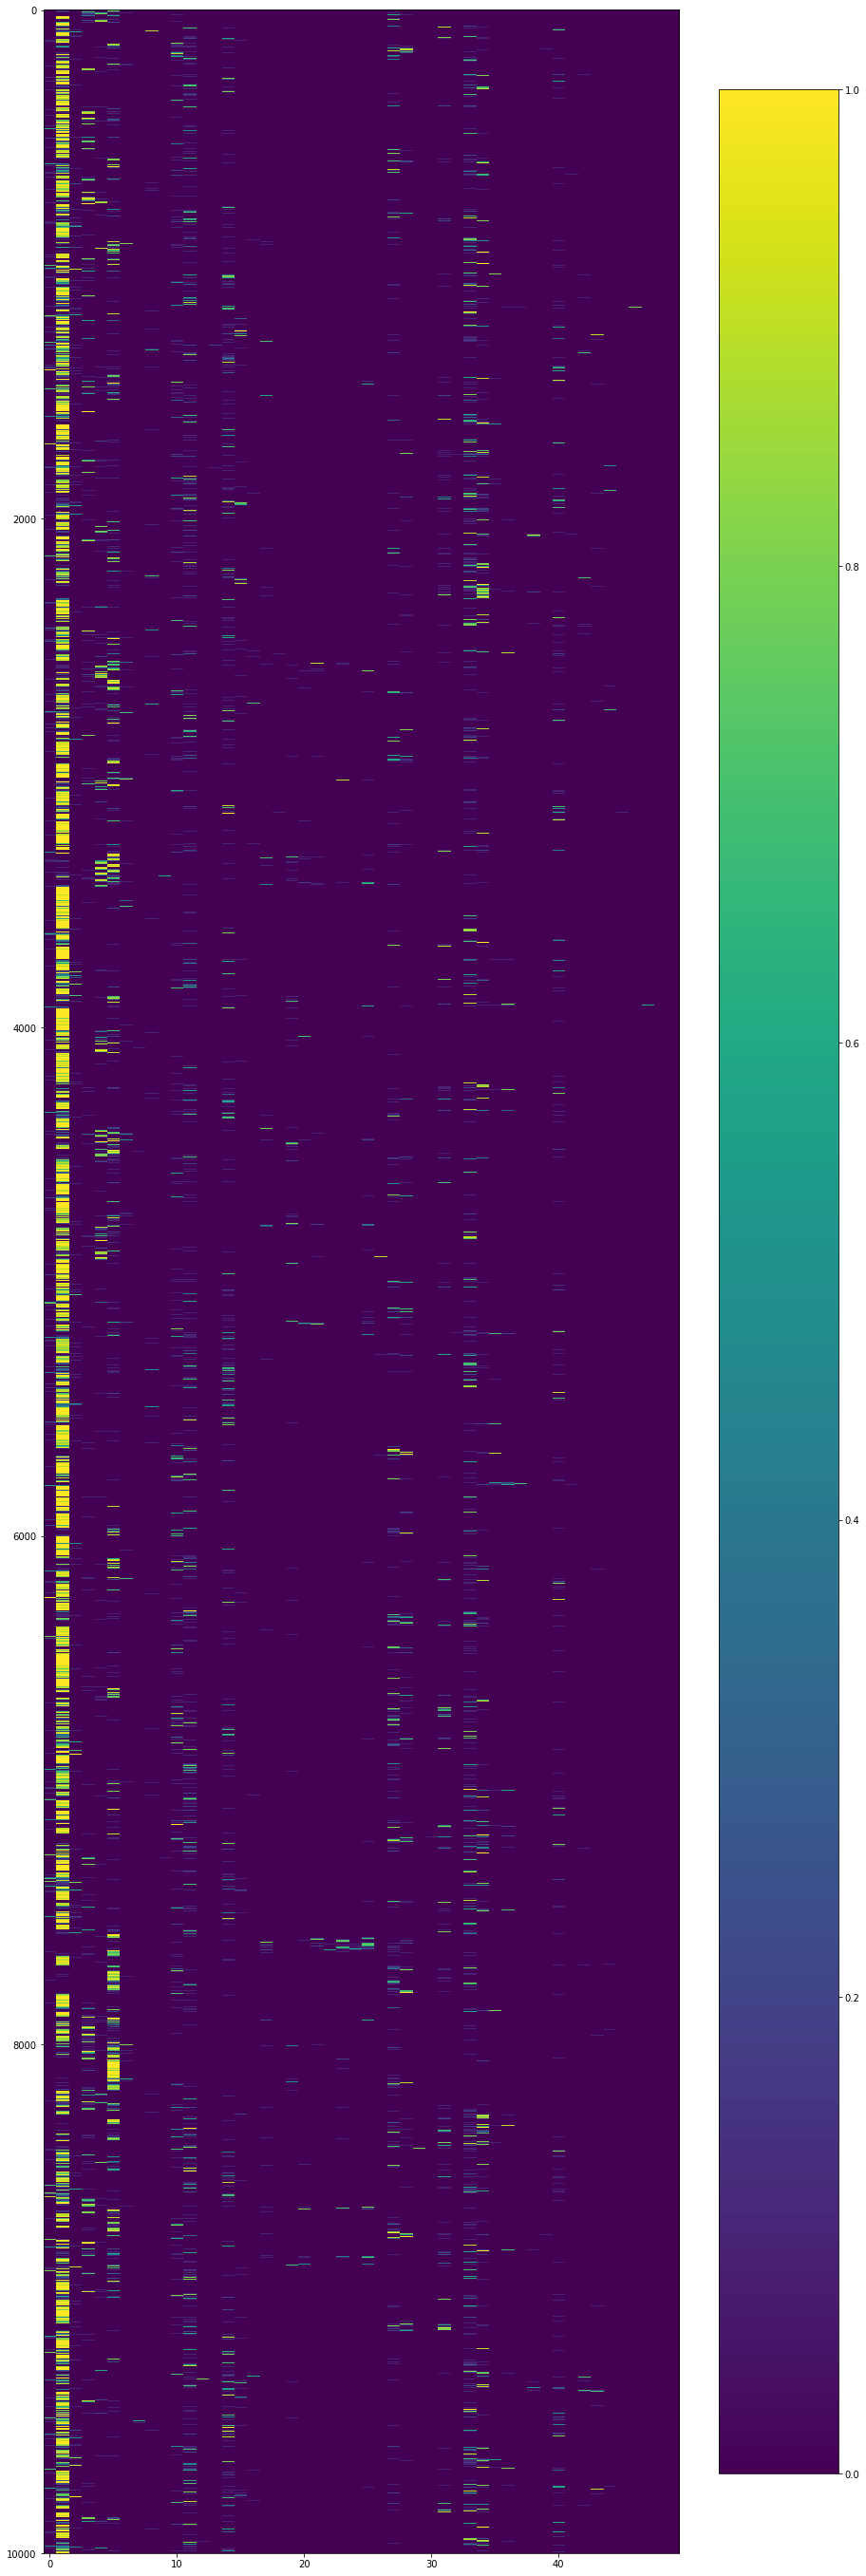

In [201]:
plt.figure(figsize=(15, 100))
plt.imshow(rforest.predict_proba(y), aspect=1/50)
plt.colorbar()

##### AdaBoost

In [203]:
from sklearn.ensemble import AdaBoostClassifier

In [207]:
ada = AdaBoostClassifier().fit(y, data2["ww"])

In [208]:
(ada.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.5544

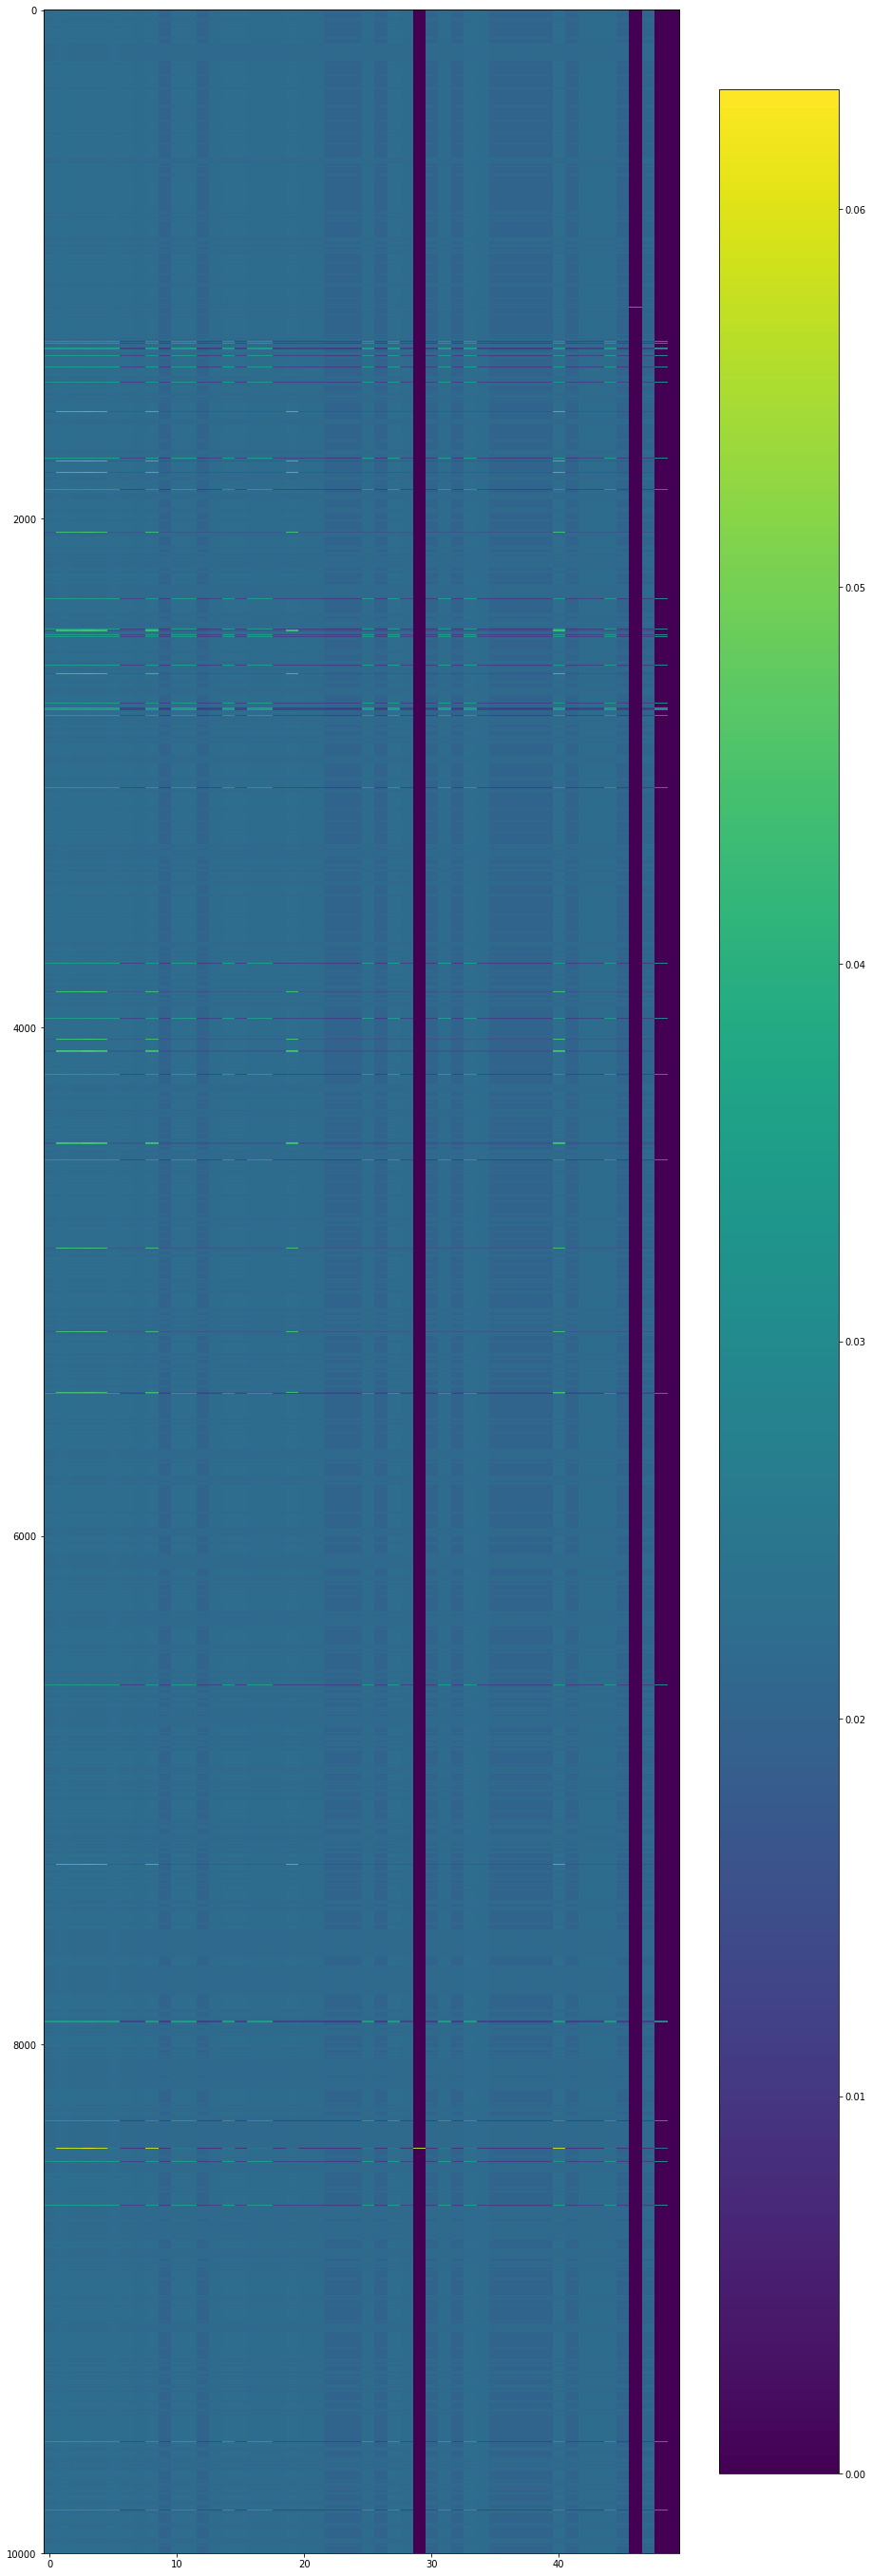

In [209]:
plt.figure(figsize=(15, 100))
plt.imshow(ada.predict_proba(y), aspect=1/50)
plt.colorbar()

### Neural Networks

In [212]:
from sklearn.neural_network import MLPClassifier

In [213]:
mlp = MLPClassifier().fit(y, data2["ww"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [215]:
(mlp.predict(y) == data2["ww"]).sum() / len(data2["ww"])

0.7482

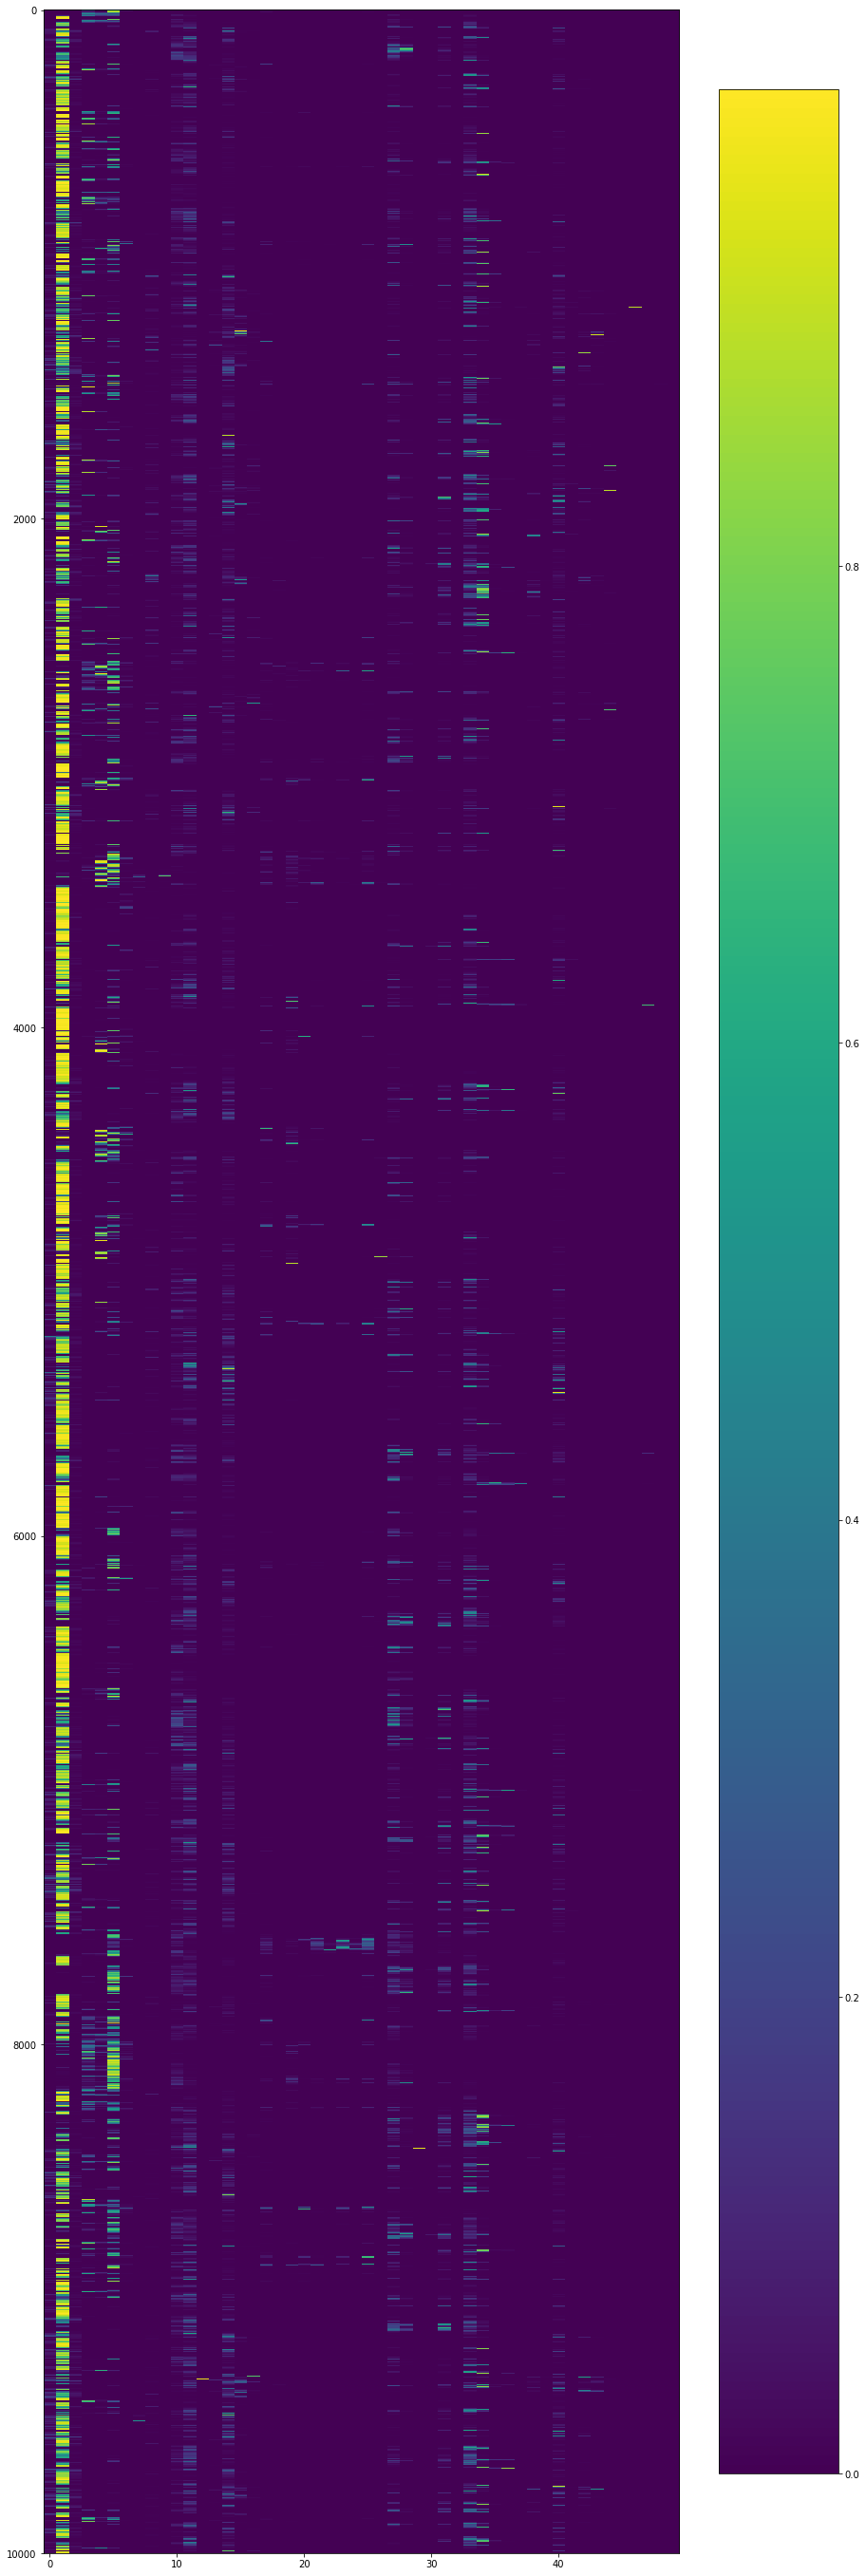

In [216]:
plt.figure(figsize=(15, 100))
plt.imshow(mlp.predict_proba(y), aspect=1/50)
plt.colorbar()

Text(0.5,1,'Layer 0 weights')

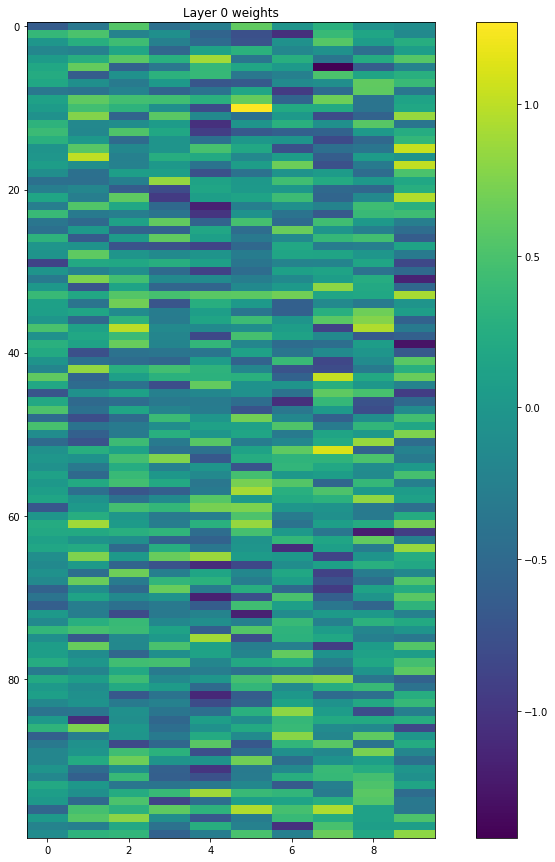

In [228]:
plt.figure(figsize=(15, 15))
plt.imshow(mlp.coefs_[0].T, aspect=1/5)
plt.colorbar()
plt.title("Layer 0 weights")

Text(0.5,1,'Layer 1 weights')

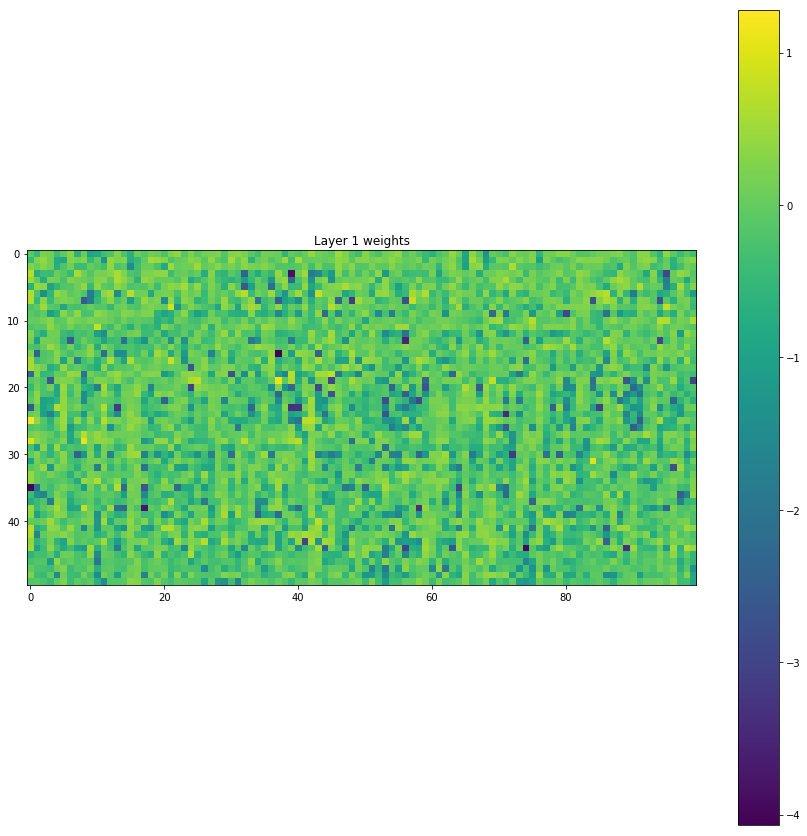

In [233]:
plt.figure(figsize=(15, 15))
plt.imshow(mlp.coefs_[1].T, aspect=1)
plt.colorbar()
plt.title("Layer 1 weights")

(100, 50)